In [ ]:
from typing import Dict, List, Tuple, Optional, Union
import silence_tensorflow.auto
import time
from utils.models_tuner import *
from utils.data_processing import to_bed

In [ ]:
from ucsc_genomes_downloader import Genome

genome = Genome("hg38", cache_directory=GENOME_CACHE_DIR)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

holdouts_generator = StratifiedShuffleSplit(
    n_splits=HOLDOUTS_NUM_SPLIT,
    test_size=TEST_SIZE
)

In [ ]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data
from utils.bio_constants import *
import warnings
warnings.filterwarnings('ignore')

all_tuner_results = []
all_input_layer = []
all_output_layer = []

for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    all_results = []
    task_name = task.__name__

    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=CELL_LINE,
        window_size=WINDOW_SIZE,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold,
        root="bio_data/epigenomic/"+str(task_name),
        verbose=1
    )
    bed = to_bed(X)

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=HOLDOUTS_NUM_SPLIT,
        leave=False,
        desc="Computing Holdouts For {}".format(task_name)
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]

        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)

        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()

        input_layers = {}
        output_layers = {}
        for model in MODELS_TYPE:
            if model == MODEL_TYPE_MMNN:
                check_ffn_param = any("ffnn_parameters" in d for d in all_tuner_results[:2])
                check_cnn_param = any("cnn_parameters" in d for d in all_tuner_results[:2])
                if check_ffn_param and check_cnn_param:
                    input_layers["input_epigenomic_data"] = all_tuner_results[0].get("ffnn_parameters").get("input_epigenomic_data")
                    input_layers["input_sequence_data"] = all_tuner_results[1].get("cnn_parameters").get("input_sequence_data")
                    output_layers["last_hidden_ffnn"] = all_tuner_results[0].get("ffnn_parameters").get("last_hidden_ffnn")
                    output_layers["last_hidden_cnn"] = all_tuner_results[1].get("cnn_parameters").get("last_hidden_cnn")
                    #print(f"check_ffn_param: {check_ffn_param} check_cnn_param: {check_cnn_param} input_layers: {input_layers} output_layers: {output_layers} ")
            tuner_result = hyperparameter_tuning(train_X,
                                                test_X,
                                                train_y,
                                                test_y,
                                                train_bed,
                                                test_bed,
                                                genome,
                                                WINDOW_SIZE,
                                                holdout_number,
                                                task_name, model,
                                                input_layers,
                                                output_layers)
            all_tuner_results.append(tuner_result)

In [ ]:
all_tuner_results[:3]

In [ ]:
from utils.models.build_binary_classification_mmnn import build_binary_classification_mmnn
from utils.models.build_binary_classification_cnn import build_binary_classification_cnn
from utils.models.build_binary_classification_ffnn import build_binary_classification_ffnn
from tqdm.auto import tqdm
from utils.data_processing import *
from utils.evaluations import train_model
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data
import time
import warnings
warnings.filterwarnings('ignore')

# Create a list to store all the computed performance
all_binary_classification_performance = []

training_histories = {}

# For each task
for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    start_time = time.time()
    task_name = task.__name__
    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=CELL_LINE,
        window_size=WINDOW_SIZE,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold,
        root="bio_data/epigenomic/"+str(task_name),
        verbose=1
    )
    training_histories[task_name] = []

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=HOLDOUTS_NUM_SPLIT,
        leave=False,
        desc="Computing Holdouts For {}".format(task_name)
    ):

        for use_feature_selection in tqdm((True, False), desc="Running Feature Selection For {}".format(task_name), leave=False):
            # Get the training and test data
            train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
            train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
            train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]

            # Impute and normalize the epigenomic data
            train_X, test_X = normalize_epigenomic_data(train_X, test_X)

            # Flatten the output values
            train_y = train_y.values.flatten()
            test_y = test_y.values.flatten()

            if use_feature_selection:
                kept_features, discarded_features = execute_boruta_feature_selection(
                    X_train=pd.DataFrame(train_X),
                    y_train=train_y,
                    holdout_number=holdout_number,
                    task_name=task_name,
                    max_iter=20
                )

                if len(kept_features) > 0:
                    train_X = train_X[:,kept_features]
                    test_X = test_X[:,kept_features]

            # Get the number of features of this specific dataset
            number_of_features = train_X.shape[1]
            ffnn_parameters = all_tuner_results[0].get("ffnn_parameters")
            cnn_parameters = all_tuner_results[1].get("cnn_parameters")
            mmnn_parameters = all_tuner_results[2].get("mmnn_parameters")

            ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, hp_param=ffnn_parameters)
            cnn, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=WINDOW_SIZE, hp_param=cnn_parameters)
            mmnn_simple = build_binary_classification_mmnn(hp_param_ffnn=ffnn_parameters,
                                                            hp_param_cnn=cnn_parameters,
                                                            hp_param_mmnn=mmnn_parameters,
                                                            input_shape=number_of_features,
                                                            window_size=WINDOW_SIZE
            )
            
            mmnn_boosted = build_binary_classification_mmnn(
                hp_param_mmnn=mmnn_parameters,
                input_sequence_data=input_sequence_data,
                input_epigenomic_data=input_epigenomic_data,
                last_hidden_ffnn=last_hidden_ffnn,
                last_hidden_cnn=last_hidden_cnn
            )
            
            for model, train_sequence, test_sequence in tqdm(
                (
                    (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                    (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                    (mmnn_simple, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                    (mmnn_boosted, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                ),
                desc="Training models",
                leave=False
            ):

                # We compute the model performance
                history, performance = train_model(
                    model,
                    model.name+"V1",
                    task_name,
                    CELL_LINE,
                    train_sequence,
                    test_sequence,
                    holdout_number,
                    use_feature_selection,
                    start_time
                )
                training_histories[task_name].append(history)
                # We chain the computed performance to the performance list
                all_binary_classification_performance.append(performance)

                start_time = time.time()

# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)

In [161]:
import datetime

current_timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
all_binary_classification_performance.to_csv(f"all_binary_classification_performance_{current_timestamp}.csv", index=False)

In [90]:
all_binary_classification_performance = pd.read_csv("all_binary_classification_performance.csv")

In [91]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,markedness,LR_pos,LR_neg,DOR,run_type,model_name,task,holdout_number,use_feature_selection,elapsed_time
0,0.148190,0.956091,0.187243,0.647226,0.811951,0.358458,0.290456,0.591049,0.994855,0.812757,...,0.607667,36.389324,0.816961,1.445279,train,BinaryClassificationFFNNV1,active_enhancers_vs_inactive_enhancers,0,True,223.78
1,0.148476,0.956072,0.197368,0.638298,0.808314,0.361206,0.301508,0.595862,0.994356,0.802632,...,0.599161,34.971321,0.807187,1.474405,test,BinaryClassificationFFNNV1,active_enhancers_vs_inactive_enhancers,0,True,223.78
2,0.193074,0.952003,0.000000,0.000000,0.505954,0.048193,0.000000,0.500000,1.000000,1.000000,...,-0.047997,0.000000,1.000000,1.000000,train,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,0,True,244.98
3,0.193035,0.951963,0.000000,0.000000,0.511552,0.048369,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,0,True,244.98
4,0.152179,0.955361,0.123045,0.698598,0.808821,0.357955,0.209237,0.560184,0.997324,0.876955,...,0.656148,45.971432,0.879308,1.273680,train,MMNNV1,active_enhancers_vs_inactive_enhancers,0,True,289.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.555913,0.758672,0.539124,0.527868,0.779245,0.517455,0.533437,0.686649,0.834174,0.460876,...,0.368204,3.251143,0.552494,2.191308,test,BinaryClassificationCNNV1,active_promoters_vs_inactive_promoters,9,False,1742.15
316,0.397336,0.813451,0.581503,0.651900,0.864227,0.659626,0.614693,0.737360,0.893217,0.418497,...,0.513134,5.445647,0.468527,2.807495,train,MMNNV1,active_promoters_vs_inactive_promoters,9,False,564.20
317,0.403303,0.808029,0.571009,0.639991,0.857548,0.641662,0.603536,0.730274,0.889539,0.428991,...,0.497736,5.169335,0.482262,2.707470,test,MMNNV1,active_promoters_vs_inactive_promoters,9,False,564.20
318,0.404070,0.801337,0.776398,0.584134,0.873934,0.683917,0.666681,0.793155,0.809913,0.223602,...,0.497423,4.084431,0.276082,3.834544,train,BoostedMMNNV1,active_promoters_vs_inactive_promoters,9,False,889.48


In [152]:
all_binary_classification_performance[all_binary_classification_performance.run_type == 'test'].sort_values(by='AUPRC', ascending=False)

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,markedness,LR_pos,LR_neg,DOR,run_type,model_name,task,holdout_number,use_feature_selection,elapsed_time
167,0.389686,0.811433,0.645540,0.627973,0.864838,0.667554,0.636635,0.757011,0.868483,0.354460,...,0.504892,4.908411,0.408137,3.115420,test,BoostedMMNNV1,active_promoters_vs_inactive_promoters,0,True,741.58
223,0.389268,0.813736,0.641236,0.634656,0.866268,0.667007,0.637929,0.757147,0.873058,0.358764,...,0.510838,5.051388,0.410928,3.117715,test,BoostedMMNNV1,active_promoters_vs_inactive_promoters,3,False,786.45
175,0.397754,0.809681,0.667840,0.618702,0.864033,0.665621,0.642333,0.763150,0.858459,0.332160,...,0.501267,4.718365,0.386925,3.222079,test,BoostedMMNNV1,active_promoters_vs_inactive_promoters,0,False,535.91
215,0.387973,0.813435,0.642214,0.633661,0.866085,0.664636,0.637909,0.757266,0.872318,0.357786,...,0.510047,5.029773,0.410155,3.119735,test,BoostedMMNNV1,active_promoters_vs_inactive_promoters,3,True,520.51
217,0.401631,0.812835,0.504304,0.681470,0.863778,0.661813,0.579651,0.711620,0.918937,0.495696,...,0.524992,6.221132,0.539424,2.467651,test,BinaryClassificationFFNNV1,active_promoters_vs_inactive_promoters,3,False,141.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,0.228638,0.951963,0.000000,0.000000,0.496028,0.047674,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,2,True,277.76
155,0.199247,0.951963,0.000000,0.000000,0.495419,0.047596,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,9,False,399.21
147,0.199948,0.951963,0.000000,0.000000,0.497886,0.047397,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,9,True,337.09
99,0.192886,0.951963,0.000000,0.000000,0.494943,0.047300,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,6,True,394.75


In [24]:
# Slightly adapting the dataframe in order to visualiza it better
all_binary_classification_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection else "No Feature Selection"
    for use_selection in all_binary_classification_performance["use_feature_selection"]
]
all_performance = all_binary_classification_performance.drop(columns=["holdout_number"])

Rendering barplots: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


((<Figure size 1600x1240 with 1 Axes>,
  <Figure size 1600x1240 with 1 Axes>,
  <Figure size 1600x1240 with 1 Axes>,
  <Figure size 1600x1240 with 1 Axes>),
 (array([<AxesSubplot:title={'center':'AUROC'}, xlabel='AUROC'>],
        dtype=object),
  array([<AxesSubplot:title={'center':'Loss'}, xlabel='Loss'>], dtype=object),
  array([<AxesSubplot:title={'center':'AUPRC'}, xlabel='AUPRC'>],
        dtype=object),
  array([<AxesSubplot:title={'center':'Accuracy'}, xlabel='Accuracy'>],
        dtype=object)))

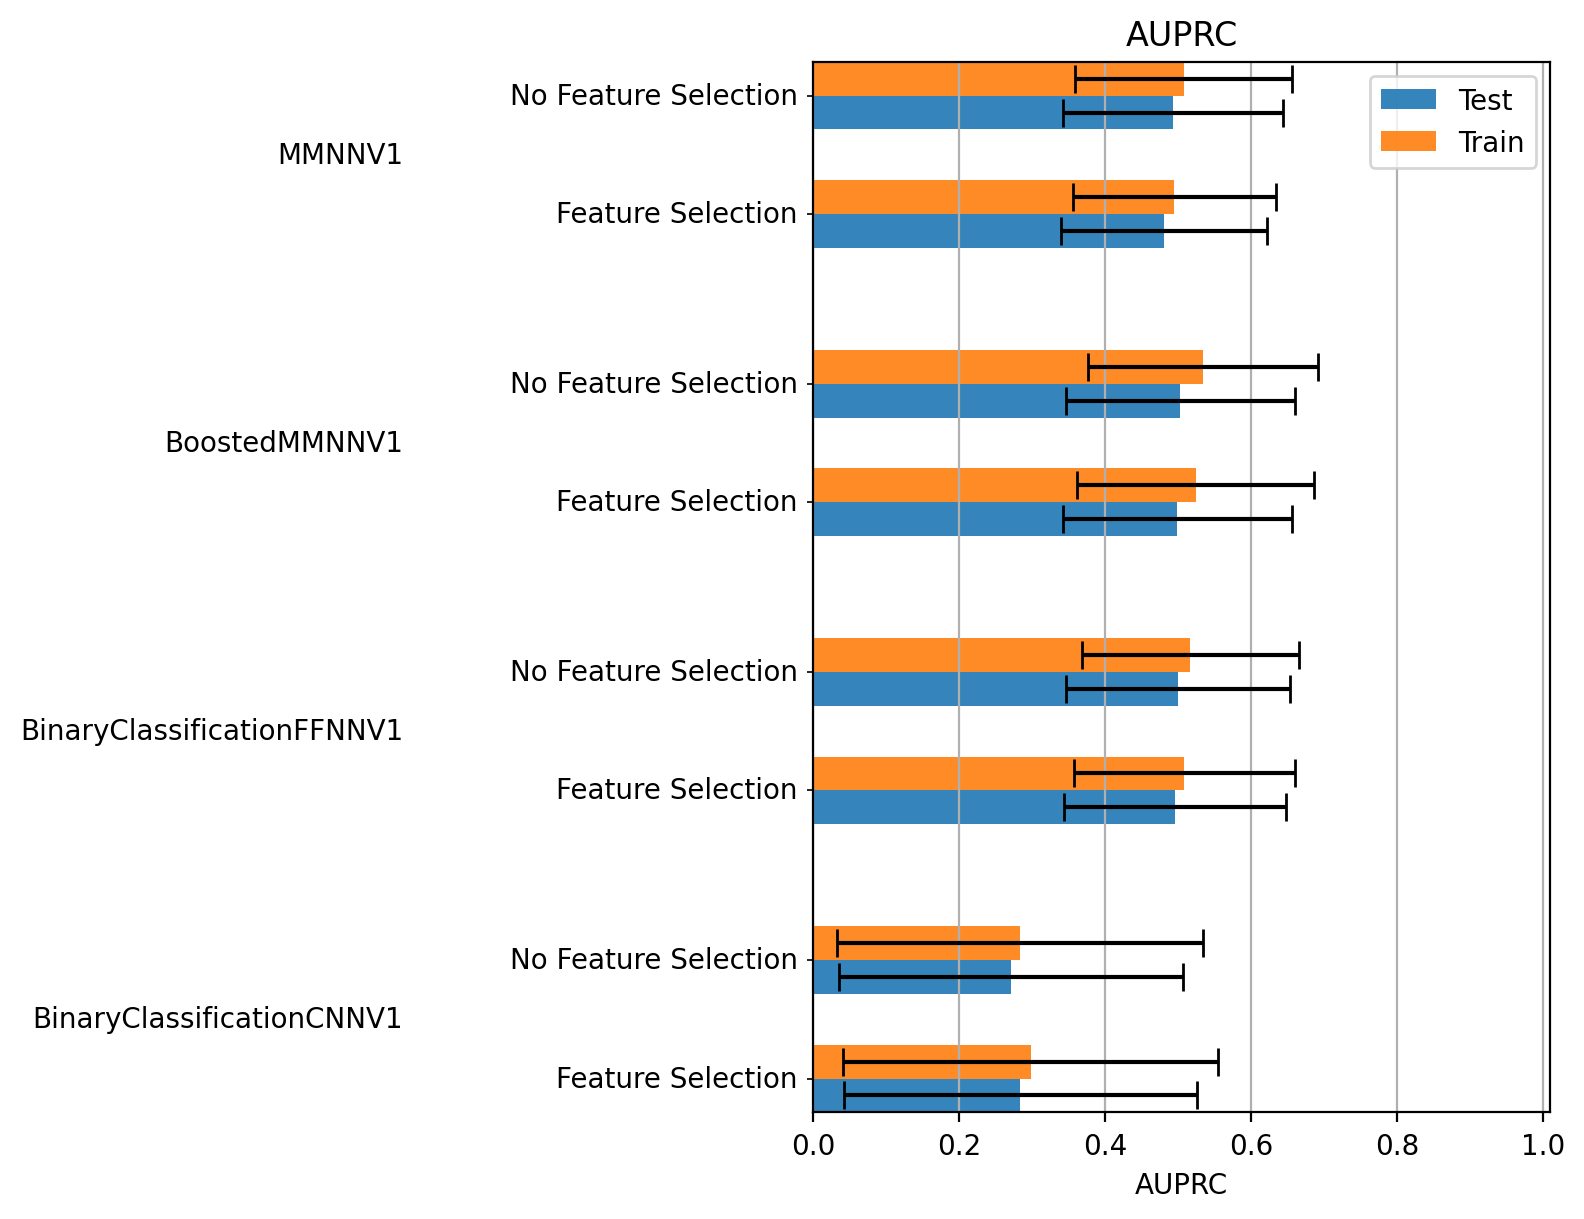

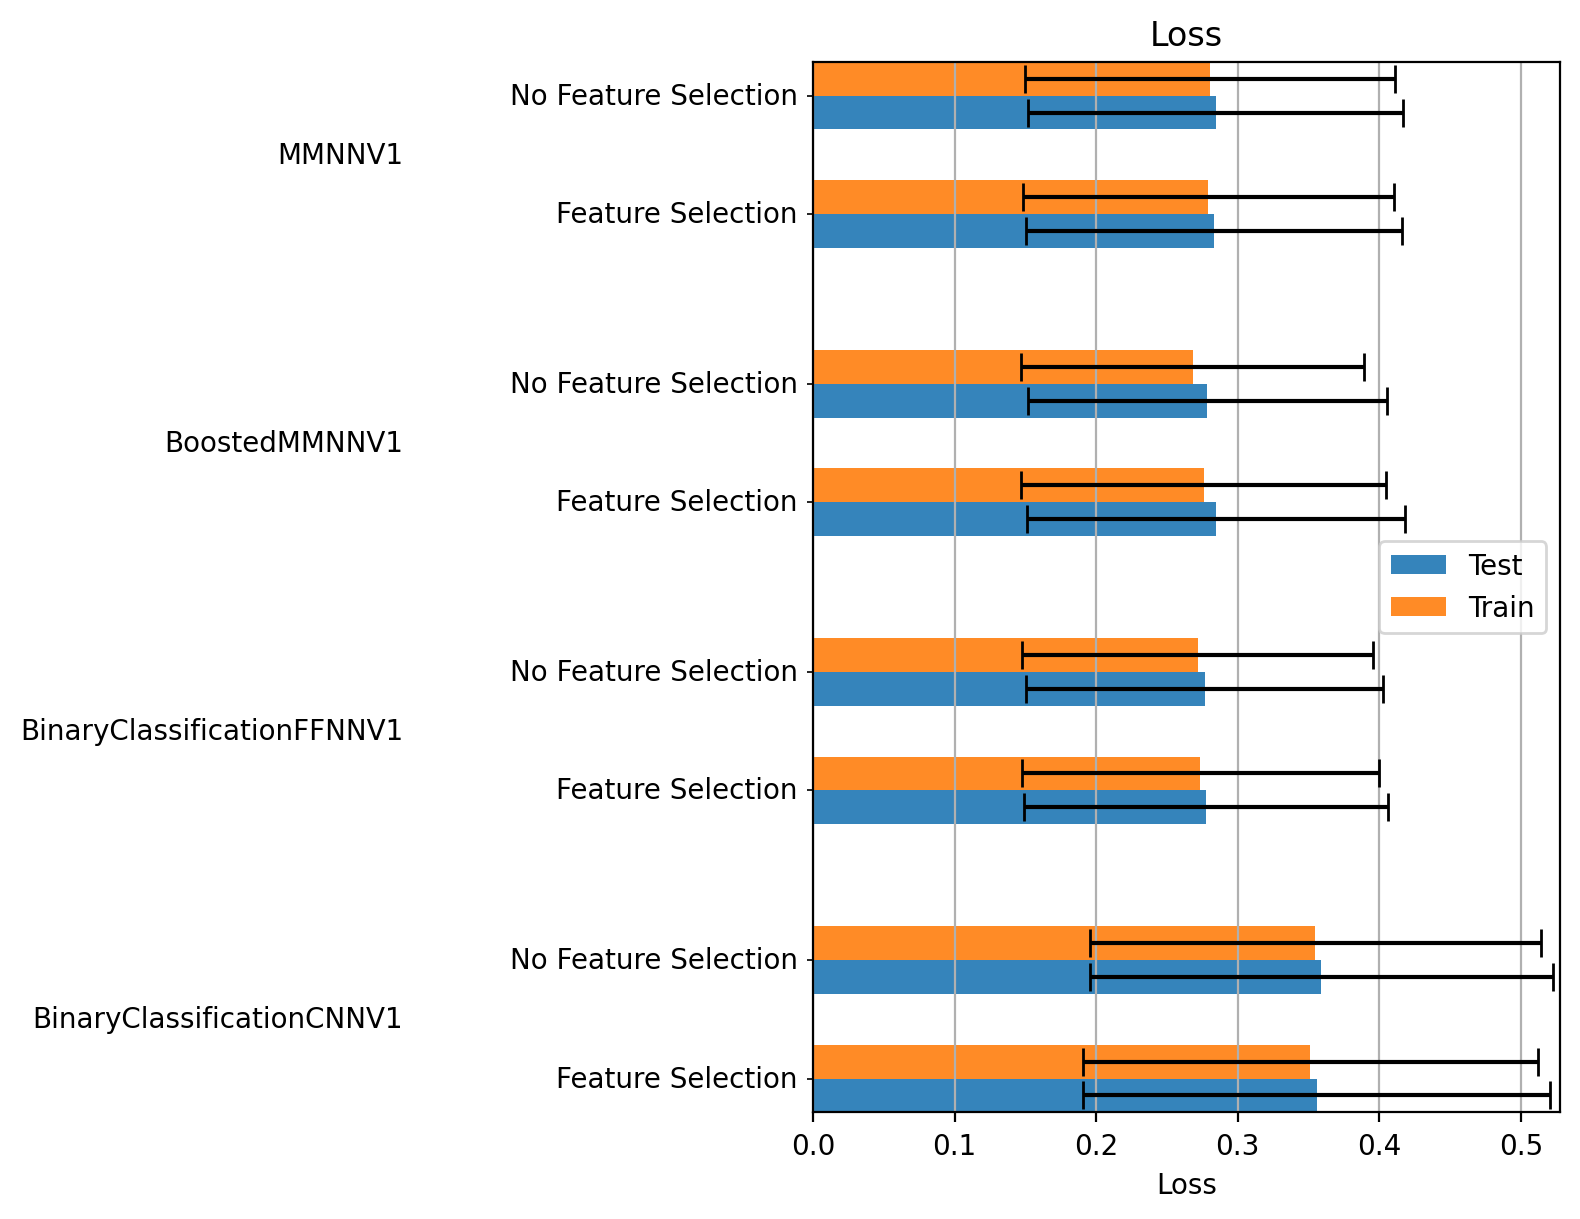

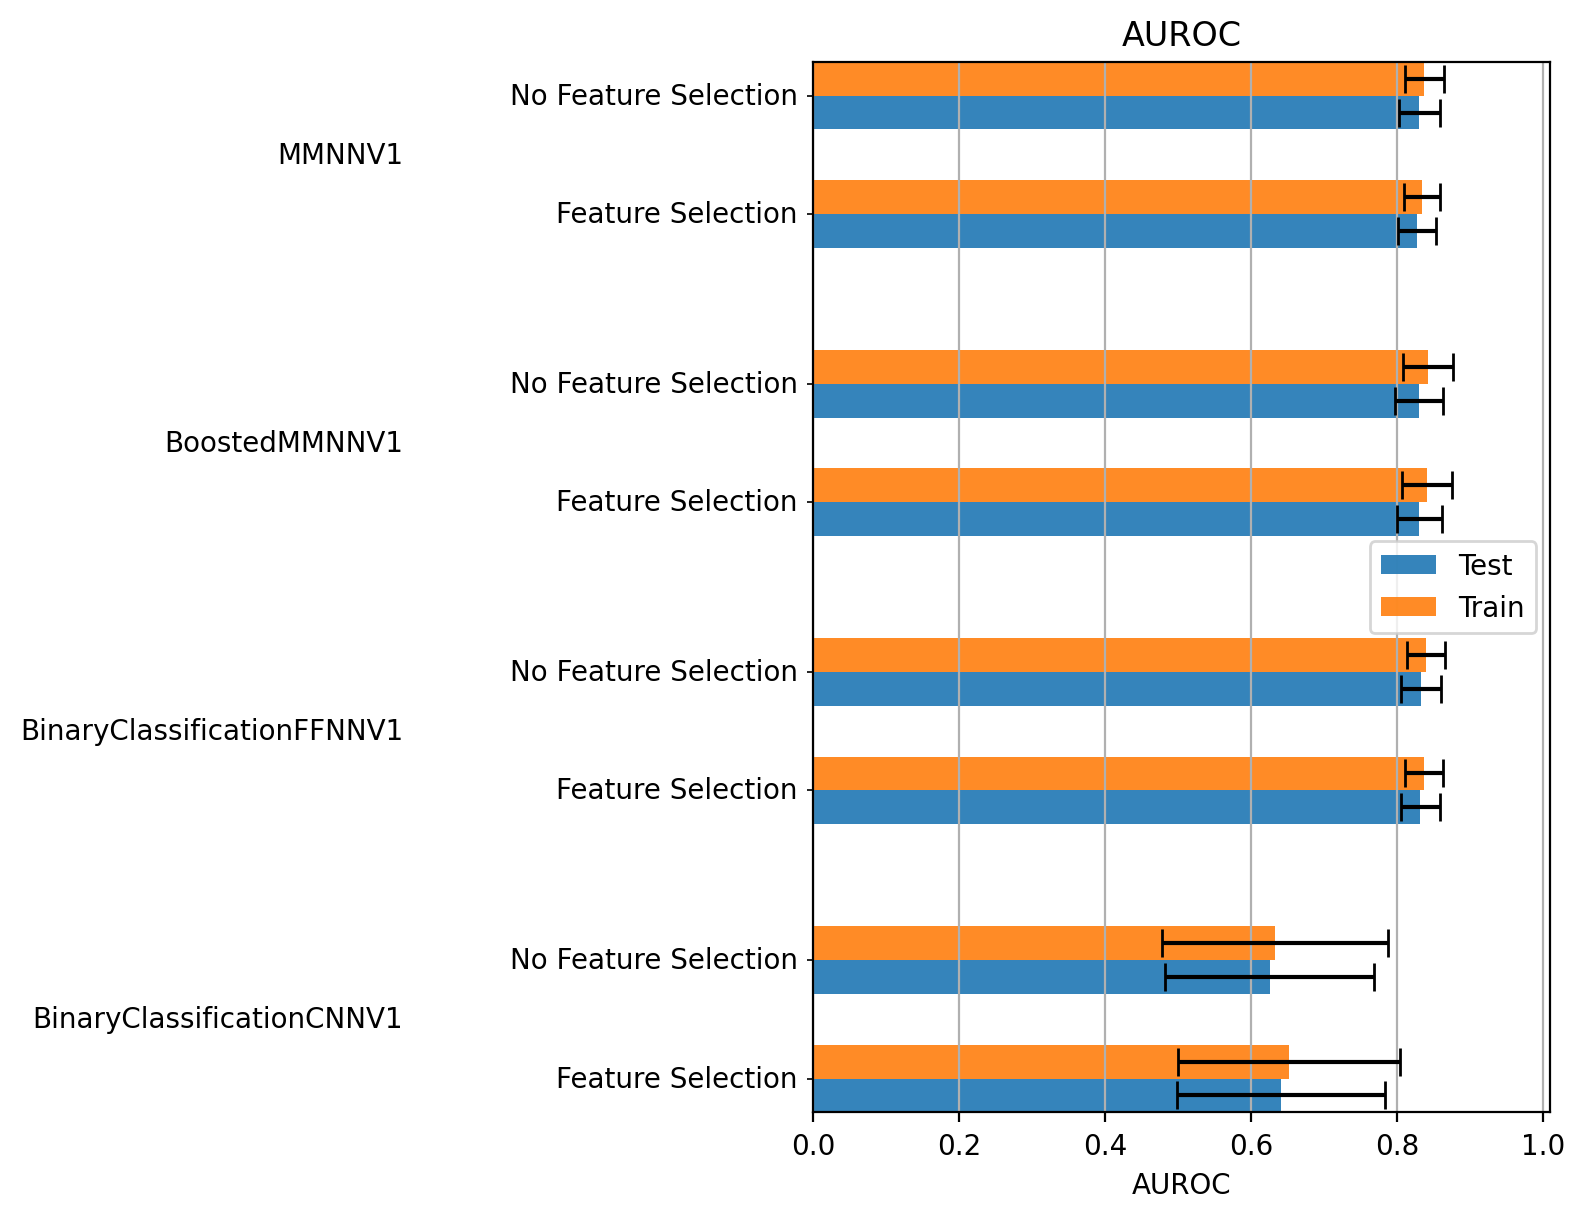

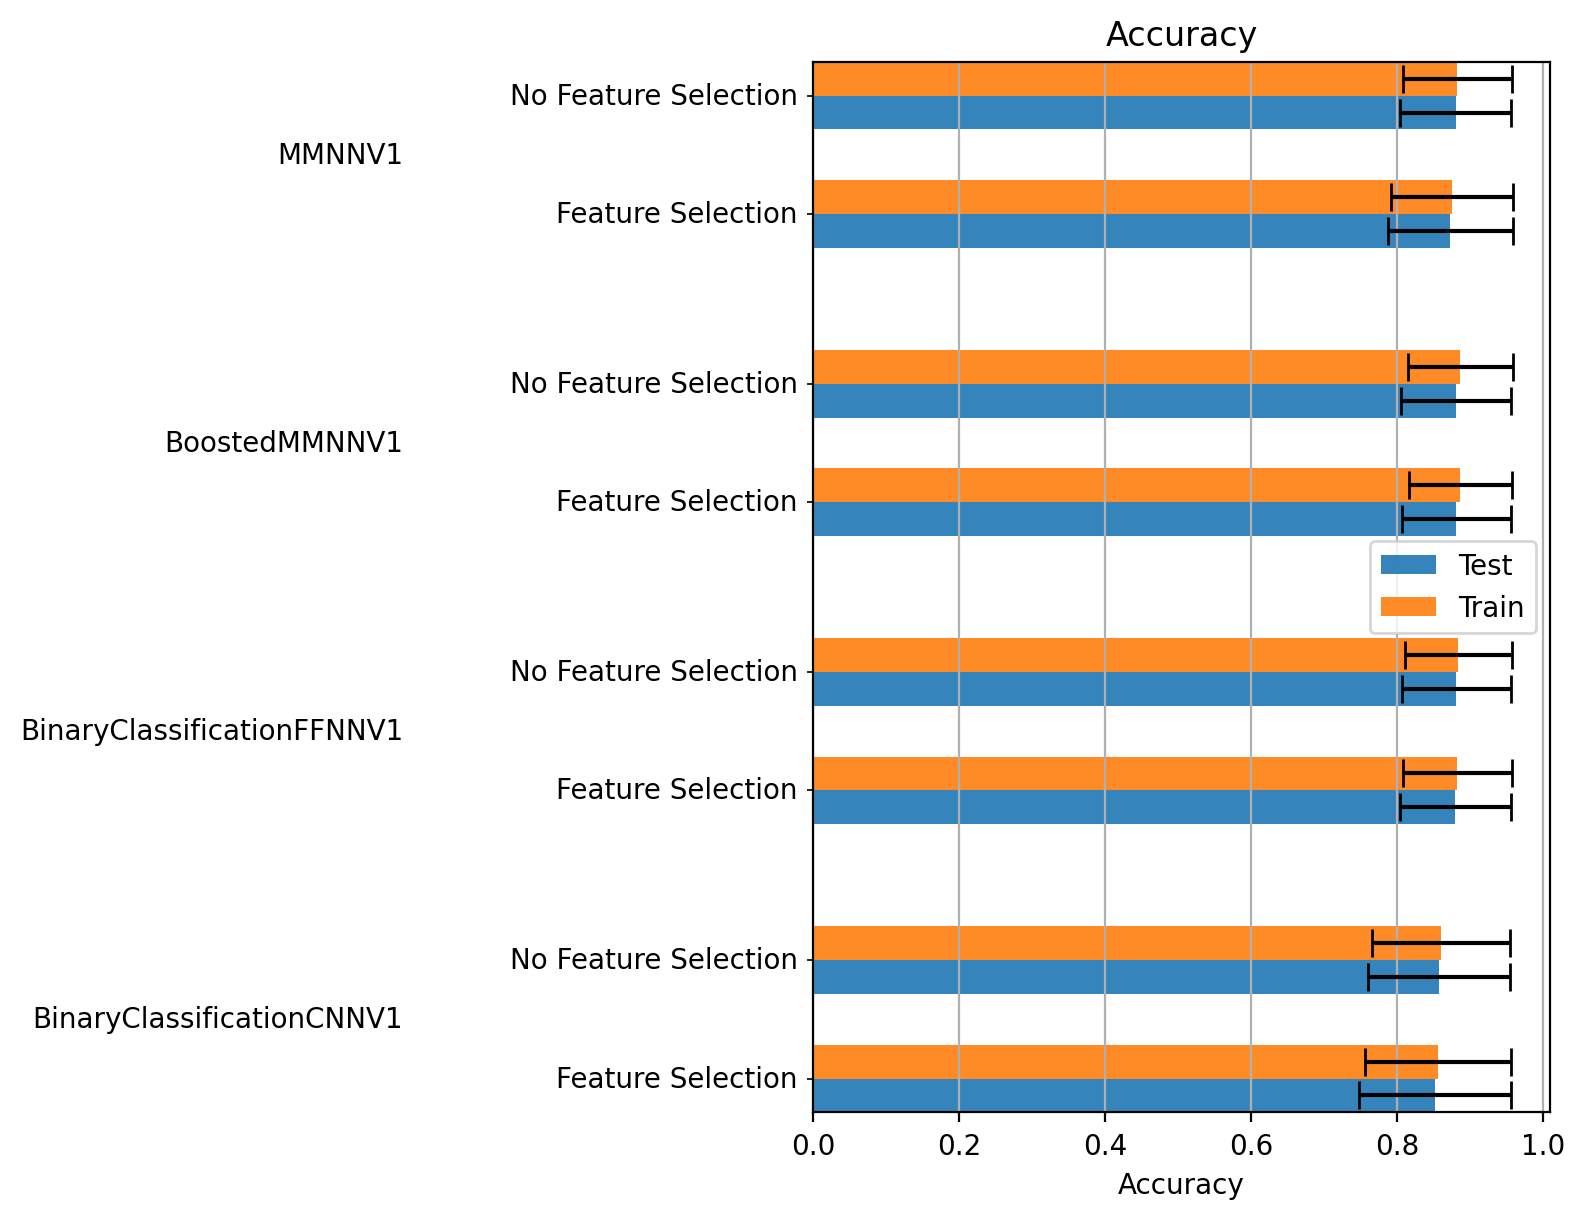

In [137]:
from barplots import barplots

column_to_filter = ["model_name", "loss", "accuracy", "AUROC", "AUPRC", "use_feature_selection", "run_type"]
barplots(
    all_performance[column_to_filter],
    groupby=["model_name", "use_feature_selection", "run_type"],
    orientation="horizontal",
    height=8,
    bar_width=0.2
)

In [135]:
from scipy.stats import wilcoxon

for model in all_binary_classification_performance.model_name.unique():
    model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "accuracy"):
        print(
            model,
            metric,
            wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
        )
    print("="*100)

BinaryClassificationFFNNV1 AUPRC WilcoxonResult(statistic=17.0, pvalue=0.0003948211669921875)
BinaryClassificationFFNNV1 AUROC WilcoxonResult(statistic=69.0, pvalue=0.1893482208251953)
BinaryClassificationFFNNV1 accuracy WilcoxonResult(statistic=57.0, pvalue=0.21453736472050733)
BinaryClassificationCNNV1 AUPRC WilcoxonResult(statistic=75.0, pvalue=0.2773551940917969)
BinaryClassificationCNNV1 AUROC WilcoxonResult(statistic=105.0, pvalue=1.0)
BinaryClassificationCNNV1 accuracy WilcoxonResult(statistic=20.0, pvalue=0.4445867389117455)
MMNNV1 AUPRC WilcoxonResult(statistic=87.0, pvalue=0.5216732025146484)
MMNNV1 AUROC WilcoxonResult(statistic=88.0, pvalue=0.5458755493164062)
MMNNV1 accuracy WilcoxonResult(statistic=74.0, pvalue=0.26109886169433594)
BoostedMMNNV1 AUPRC WilcoxonResult(statistic=42.0, pvalue=0.017181396484375)
BoostedMMNNV1 AUROC WilcoxonResult(statistic=100.0, pvalue=0.8694877624511719)
BoostedMMNNV1 accuracy WilcoxonResult(statistic=74.0, pvalue=0.39806292572561963)


In [149]:
from scipy.stats import wilcoxon

for model in all_binary_classification_performance.model_name.unique():
    model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "accuracy"):
        try:
                _, p_value = wilcoxon(
                    performance_with_feature_selection[metric],
                    performance_without_feature_selection[metric])
                # when p_value is less than the significance level, then the null
                # hypothesis is rejected and the model with greater mean for the
                # current metric is better than the other.
                if p_value < 0.01:
                    if performance_with_feature_selection.mean() > performance_without_feature_selection.mean():
                        print(f"{model} shows better results for {metric} with feature selection.")
                    else:
                        print(f"{model} shows better results for {metric} without feature selection.")
                else:
                    print(f"{model} shows statistically indistinguishiable results for {metric} with and without feature selection.")
        except ValueError:
            # this situation occurs when the matric are exactly the same.
            print(f"{model} has the same values for {metric}")
    print("="*130)

BinaryClassificationFFNNV1 has the same values for AUPRC
BinaryClassificationFFNNV1 shows statistically indistinguishiable results for AUROC with and without feature selection.
BinaryClassificationFFNNV1 shows statistically indistinguishiable results for accuracy with and without feature selection.
BinaryClassificationCNNV1 shows statistically indistinguishiable results for AUPRC with and without feature selection.
BinaryClassificationCNNV1 shows statistically indistinguishiable results for AUROC with and without feature selection.
BinaryClassificationCNNV1 shows statistically indistinguishiable results for accuracy with and without feature selection.
MMNNV1 shows statistically indistinguishiable results for AUPRC with and without feature selection.
MMNNV1 shows statistically indistinguishiable results for AUROC with and without feature selection.
MMNNV1 shows statistically indistinguishiable results for accuracy with and without feature selection.
BoostedMMNNV1 shows statistically ind